# [Computational Social Science] Project 4: Unsupervised Learning

Group 2: Ryan Karnoski, Benjamin Fields, Christopher Crawford

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

In [2]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

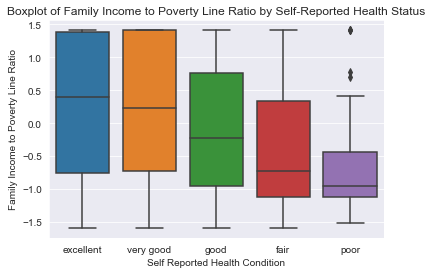

In [3]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

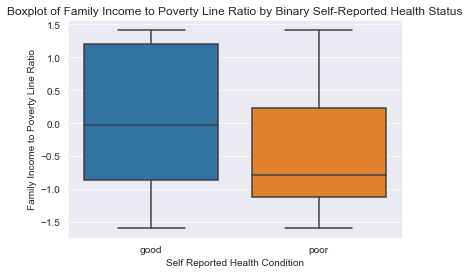

In [4]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

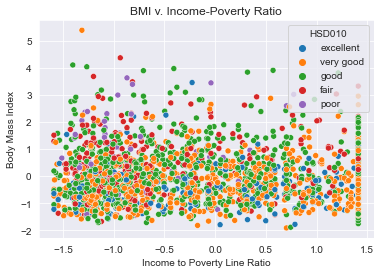

In [5]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [6]:
nhanes_scaled_x = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)
nhanes_scaled_x.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ033,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,-0.680203,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,-0.680203,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,-0.680203,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,-0.680203,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-0.680203,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812


## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components.
- Plot a barplot of the variation explains by each component.
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

In [7]:
#using svd_solver to select components that account for 90% of the variance 
pca = PCA(n_components=0.9, svd_solver = 'full')
PC_nhanes = pca.fit_transform(nhanes_scaled_x)
PC_nhanes.shape

(2064, 120)

In [8]:
ncomp = PC_nhanes.shape[1]
pca.explained_variance_ratio_.sum()

0.9020576804579694

### Barplot of Components

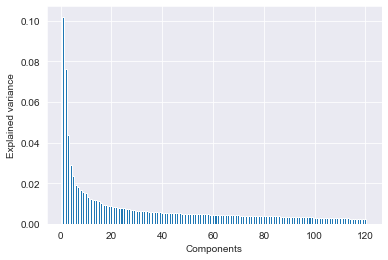

In [9]:
plt.bar(range(1,len(pca.explained_variance_ratio_)+1),pca.explained_variance_ratio_)
plt.ylabel('Explained variance')
plt.xlabel('Components');

*Fig. 1* 

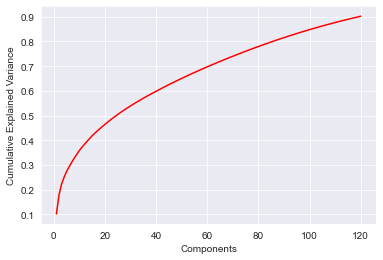

In [10]:
plt.plot(range(1,len(pca.explained_variance_ratio_)+1),
        np.cumsum(pca.explained_variance_ratio_),
               c='red',
               label="Cumulative Explained Variance")
plt.ylabel('Cumulative Explained Variance')
plt.xlabel('Components');

*Fig. 2*

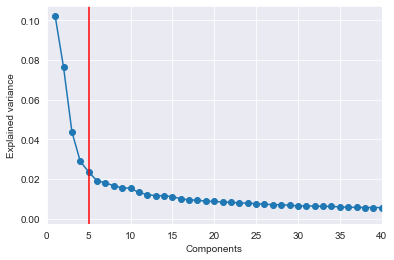

In [11]:
plt.plot(range(1,len(pca.explained_variance_ratio_)+1),pca.explained_variance_ratio_)
plt.scatter(range(1,len(pca.explained_variance_ratio_)+1),pca.explained_variance_ratio_)
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.axvline(5, c='r')
plt.xlim(0,40)
plt.show();

*Fig. 3* 

### How many components will you use to fit a supervised learning model?

Based on the above plots, it appears that the first ~5 components provide the greatest explanation of the variance in the dataset (Fig. 1). In total, the "most impactful" components still only account for ~25% of the total variance.

### 2D Scatterplot of the first two components

In [41]:
pca_df=pd.DataFrame(data = PC_nhanes,
                   columns = ['principal component %i' %n for n in range(1, ncomp + 1)])
pca_df['SEQN'] = seqn
pca_df = pca_df.set_index(['SEQN'])

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5
SEQN,,,,,
73568,9.527811,-0.816224,-1.867091,-2.109908,-3.929375
73576,-5.838339,-3.692573,3.805749,-1.029680,0.394578
73579,-0.719454,-2.573200,0.907904,-4.755854,-1.798847
73581,3.533627,-2.576982,-3.249124,-0.405426,3.999037
73584,-6.872094,-4.194241,0.886831,-0.848954,-0.524848


<Figure size 432x288 with 0 Axes>

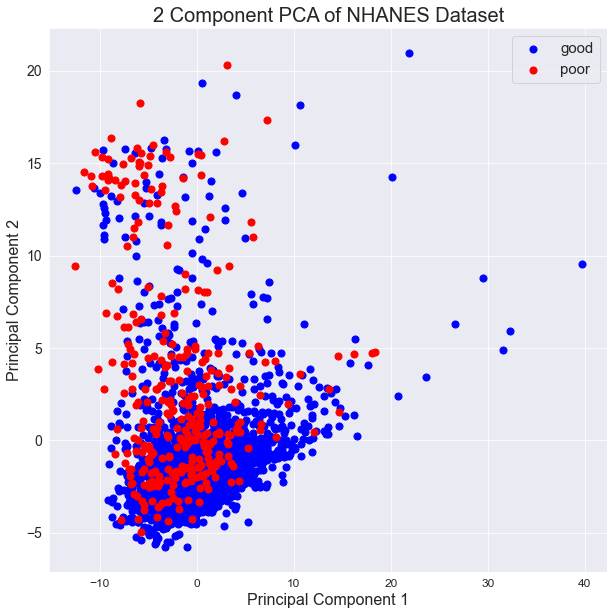

       principal component 1  principal component 2  principal component 3  \
SEQN                                                                         
73568               9.527811              -0.816224              -1.867091   
73576              -5.838339              -3.692573               3.805749   
73579              -0.719454              -2.573200               0.907904   
73581               3.533627              -2.576982              -3.249124   
73584              -6.872094              -4.194241               0.886831   

       principal component 4  principal component 5  principal component 6  \
SEQN                                                                         
73568              -2.109908              -3.929375              -0.185332   
73576              -1.029680               0.394578               1.593149   
73579              -4.755854              -1.798847               0.863651   
73581              -0.405426               3.999037            

In [44]:
#2 figure component analysis scatterplot
plt.figure();
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component 1', fontsize=16)
plt.ylabel('Principal Component 2', fontsize=16)
plt.title("2 Component PCA of NHANES Dataset",fontsize=20)
targets = ['good', 'poor']
colors = ['b', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = nhanes_scaled['HSD010_binary'] == target
    plt.scatter(pca_df.loc[indicesToKeep, 'principal component 1']
               , pca_df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)
plt.legend(targets,prop={'size':15})
plt.show();
print(pca_df.head())

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

We will use K-Means clustering, which seeks to classify observations to specific cluster based on their distance to the centroid of said cluster. Centroids are iteratively determined by minimizing the sum of the squared distances between observations and centroids. The optimal number of clusters can be determined through techniques such as the elbow method.

### Cluster nhanes

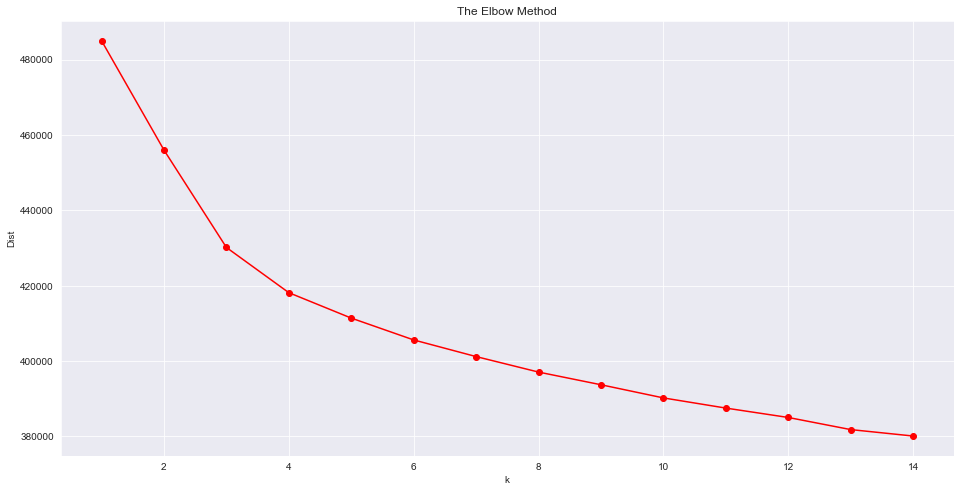

Coordinates: DR1DRSTZ Label: 0
Coordinates: DR1EXMER Label: 1
Coordinates: DRABF Label: 3
Coordinates: DRDINT Label: 3
Coordinates: DR1DBIH Label: 1
Coordinates: DR1DAY Label: 0
Coordinates: DR1LANG Label: 1
Coordinates: DR1MNRSP Label: 3
Coordinates: DR1HELPD Label: 3
Coordinates: DBQ095Z Label: 3
Coordinates: DRQSPREP Label: 3
Coordinates: DR1STY Label: 1
Coordinates: DRQSDIET Label: 3
Coordinates: DR1TNUMF Label: 1
Coordinates: DR1TKCAL Label: 3
Coordinates: DR1TPROT Label: 2
Coordinates: DR1TCARB Label: 2
Coordinates: DR1TSUGR Label: 3
Coordinates: DR1TFIBE Label: 0
Coordinates: DR1TTFAT Label: 0
Coordinates: DR1TSFAT Label: 3
Coordinates: DR1TMFAT Label: 1
Coordinates: DR1TPFAT Label: 0
Coordinates: DR1TCHOL Label: 1
Coordinates: DR1TATOC Label: 3
Coordinates: DR1TRET Label: 1
Coordinates: DR1TVARA Label: 3
Coordinates: DR1TBCAR Label: 0
Coordinates: DR1TLZ Label: 0
Coordinates: DR1TVB1 Label: 3
Coordinates: DR1TVB2 Label: 2
Coordinates: DR1TNIAC Label: 3
Coordinates: DR1TVB6 Labe

In [14]:
#set random seed
np.random.seed(42)

#make df with dropped outcomes
data = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

#find best number of clusters
dist = []
K = range(1,15)
for i in K:
    kmeanmod = KMeans(n_clusters = i, max_iter = 300)
    kmeanmod.fit(data)
    dist.append(kmeanmod.inertia_)
    
#elbow method 
plt.figure(figsize=(16,8))
plt.plot(K, dist, 'ro-')
plt.xlabel('k')
plt.ylabel('Dist')
plt.title('The Elbow Method')
plt.show()

#Elbow methods suggests that 3 or 4 clusters best fit the data. We'll use 4 going forward.

#Kmeans with 4 clusters
kmean4 = KMeans(n_clusters = 4, max_iter = 300).fit(data)

for point, label in zip(data, kmean4.labels_):
    print("Coordinates:", point, "Label:", label)

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

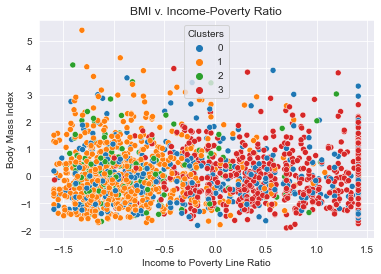

SEQN
73568    0
73576    1
73579    3
73581    3
73584    1
        ..
83694    3
83696    1
83704    1
83716    0
83721    3
Name: Clusters, Length: 2064, dtype: int32


In [46]:
data["Clusters"]=kmean4.labels_

ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "Clusters", palette = "tab10", data = data)
ax.set(xlabel = "Income to Poverty Line Ratio",
       ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

We see the most separation between clusters 1 and 3 (orange vs. red). More specifically, observations in cluster 3 have a larger income to poverty ratio than cluster 1.

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

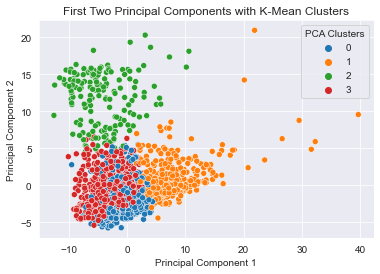

In [16]:
#PCA with 5 components from above
pca_5 = pca_df.iloc[:,0:5]
kmeanPCA = KMeans(n_clusters = 4, max_iter = 300).fit(pca_5)

# add clusters back to X df
data["PCA Clusters"]=kmeanPCA.labels_ 

#2D scatter with clusters
ax = sns.scatterplot(x = pca_5['principal component 1'], 
                     y = pca_5['principal component 2'], 
                     hue = data['PCA Clusters'], palette = "tab10")
ax.set(xlabel = "Principal Component 1",
       ylabel = "Principal Component 2")
ax.set_title("First Two Principal Components with K-Mean Clusters")
plt.show()

As shown in the 2D scatterplot above, the first two components may be better described by 3 clusters instead of 4. Indeed, clusters 0 and 1 (blue and orange) are largely overlapping, whereas clusters 2 and 3 (green and red) are well separated. Combining clusters 0 and 1 into a single cluster may better describe these first two components. 

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [27]:
#setting up the variables and data for a neural network model
y = nhanes_scaled['HSD010_binary'] #we are picking the binary because it is easier to understand and quantify
X = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1) #this is to drop all the outcome columns that aren't features
y = y.replace(["good", "poor"], [0,1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [28]:
#importing of packages and functions
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import np_utils

#converting class vectors to binary class matrices
y_train =  np_utils.to_categorical(y_train, num_classes = 2)
y_test = np_utils.to_categorical(y_test, num_classes = 2)

num_classes = y_test.shape[1]
print(num_classes)

num_columns = X_test.shape[1]
print(num_columns)

2
241


In [33]:
model = Sequential()

model.add(
    Dense(num_columns, input_dim = X_test.shape[1], kernel_initializer = 'normal', activation = 'relu')
)

model.add(
    Dense(num_classes, kernel_initializer = 'normal', activation = 'sigmoid')
)

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 10, batch_size = 200, verbose = 2)


Epoch 1/10
8/8 - 3s - loss: 0.5332 - accuracy: 0.7351 - val_loss: 0.4139 - val_accuracy: 0.8469 - 3s/epoch - 349ms/step
Epoch 2/10
8/8 - 1s - loss: 0.3269 - accuracy: 0.8702 - val_loss: 0.3971 - val_accuracy: 0.8566 - 685ms/epoch - 86ms/step
Epoch 3/10
8/8 - 1s - loss: 0.2931 - accuracy: 0.8811 - val_loss: 0.3899 - val_accuracy: 0.8566 - 749ms/epoch - 94ms/step
Epoch 4/10
8/8 - 1s - loss: 0.2600 - accuracy: 0.8953 - val_loss: 0.3805 - val_accuracy: 0.8508 - 688ms/epoch - 86ms/step
Epoch 5/10
8/8 - 0s - loss: 0.2322 - accuracy: 0.9063 - val_loss: 0.3738 - val_accuracy: 0.8411 - 343ms/epoch - 43ms/step
Epoch 6/10
8/8 - 0s - loss: 0.2089 - accuracy: 0.9180 - val_loss: 0.3714 - val_accuracy: 0.8547 - 182ms/epoch - 23ms/step
Epoch 7/10
8/8 - 0s - loss: 0.1888 - accuracy: 0.9315 - val_loss: 0.3712 - val_accuracy: 0.8430 - 192ms/epoch - 24ms/step
Epoch 8/10
8/8 - 0s - loss: 0.1716 - accuracy: 0.9386 - val_loss: 0.3734 - val_accuracy: 0.8450 - 103ms/epoch - 13ms/step
Epoch 9/10
8/8 - 0s - loss

### Neural Network on Principal Components

In [45]:
#setting up data for the PCA NN model
y = nhanes_scaled['HSD010_binary']
y = y.replace(["good", "poor"], [0,1])
X_PCA = pca_df.iloc[:, 0:5]
X_train, X_test, y_train, y_test = train_test_split(X_PCA, y, test_size = 0.25, random_state = 42)
            
#coverting class vectors to binary class matrices
y_train =  np_utils.to_categorical(y_train, num_classes = 2)
y_test = np_utils.to_categorical(y_test, num_classes = 2)
num_columns = X_test.shape[1]
num_classes = y_test.shape[1]
print(num_columns, num_classes)

#modeling
model = Sequential()

model.add(
    Dense(num_columns, input_dim = X_test.shape[1], kernel_initializer = 'normal', activation = 'relu')
)

model.add(
    Dense(num_classes, kernel_initializer = 'normal', activation = 'sigmoid')
)

model.compile (loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 10, batch_size = 200, verbose = 2)

<bound method NDFrame.head of        principal component 1  principal component 2  principal component 3  \
SEQN                                                                         
73568               9.527811              -0.816224              -1.867091   
73576              -5.838339              -3.692573               3.805749   
73579              -0.719454              -2.573200               0.907904   
73581               3.533627              -2.576982              -3.249124   
73584              -6.872094              -4.194241               0.886831   
...                      ...                    ...                    ...   
83694               2.643319              -1.689356              -0.702592   
83696               1.037906              -0.118065               5.556454   
83704               1.130253              -0.970432               3.415389   
83716               7.145093              -0.376752               1.753506   
83721               0.050869      

### Neural Network on Principal Components + Cluster Membership

In [49]:
#setting up the variables and the data
y = nhanes_scaled['HSD010_binary']
y = y.replace(["good", "poor"], [0,1])
X = X_PCA
clusters = data["Clusters"]
X = X.join(clusters) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

#coverting class vectors to binary class matrices
y_train =  np_utils.to_categorical(y_train, num_classes = 2)
y_test = np_utils.to_categorical(y_test, num_classes = 2)
num_columns = X_test.shape[1]
num_classes = y_test.shape[1]
print (num_columns, num_classes)

#modeling
model = Sequential()
model.add(
    Dense(num_columns, input_dim = X_test.shape[1], kernel_initializer = 'normal', activation = 'relu')
)
model.add(
    Dense(num_classes, kernel_initializer = 'normal', activation = 'sigmoid')
)
model.compile (loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 10, batch_size = 200, verbose = 2)

#Adding cluster membership did not change model accuracy.

6 2
Epoch 1/10
8/8 - 2s - loss: 0.6893 - accuracy: 0.6641 - val_loss: 0.6859 - val_accuracy: 0.7500 - 2s/epoch - 229ms/step
Epoch 2/10
8/8 - 0s - loss: 0.6821 - accuracy: 0.8236 - val_loss: 0.6790 - val_accuracy: 0.8295 - 172ms/epoch - 22ms/step
Epoch 3/10
8/8 - 0s - loss: 0.6745 - accuracy: 0.8424 - val_loss: 0.6717 - val_accuracy: 0.8295 - 158ms/epoch - 20ms/step
Epoch 4/10
8/8 - 0s - loss: 0.6664 - accuracy: 0.8424 - val_loss: 0.6633 - val_accuracy: 0.8295 - 164ms/epoch - 21ms/step
Epoch 5/10
8/8 - 0s - loss: 0.6571 - accuracy: 0.8424 - val_loss: 0.6538 - val_accuracy: 0.8295 - 167ms/epoch - 21ms/step
Epoch 6/10
8/8 - 0s - loss: 0.6461 - accuracy: 0.8424 - val_loss: 0.6428 - val_accuracy: 0.8295 - 163ms/epoch - 20ms/step
Epoch 7/10
8/8 - 0s - loss: 0.6336 - accuracy: 0.8424 - val_loss: 0.6300 - val_accuracy: 0.8295 - 159ms/epoch - 20ms/step
Epoch 8/10
8/8 - 0s - loss: 0.6188 - accuracy: 0.8424 - val_loss: 0.6157 - val_accuracy: 0.8295 - 156ms/epoch - 19ms/step
Epoch 9/10
8/8 - 0s - 

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

The difference between PCA and clustering is that PCA is focused on dimensionality reduction (reducing the number of features/components of interest) in a dataset, whereas clustering is used to create "clusters" of variables of interest based on responses/data points captured by the dataset.

## Your Answer Here

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

One advantage to combining PCA and clustering is that the dimensionality of the data subjected to clustering is greatly reduced. For large datasets with many variables, this combination could result in a greater signal-to-noise ratio, as the PCA data may be better representative of "signal" than the original data. Moreover, the lower-dimensionality PCA data may show greater separation between clusters than the original data, which could aid in interpretability of dervived clusters. Indeed, in the 2D scatterplot above, it is clear that the first 2 components are well described by 3 clusters.

## Your Answer Here

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

Unsupervised techniques like PCA and clustering can help with downstream supervised learning tasks for researchers working with "big data" because these techniques essentially automate the task of sorting the most impactful components of a dataset on an outcome of interest. The ability to use these techniques allows the researcher/data analyst to develop a parsimonious model that includes the key variables of interest (without having to re-run hundreds of regressions to determine which of the variables are most impactful). This is helpful for the downstream tasks because the models are less complex than they otherwise would be.